<a href="https://colab.research.google.com/github/hyeonniii/NLP/blob/main/%EA%B5%90%EC%9C%A1/0812%EA%B5%90%EC%9C%A1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN을 활용한 mnist 손글씨 생성 예제

### Initialization

In [ ]:
""" 
필요한 함수들을 불러오기: 
keras - 신경망 계산 가속화, 
tensorflow - 벡터행렬 및 미분 계산, 
numpy - 복잡한 산술계산,
matplotlib - 그래프 그리기
"""
# 필요한 함수 불러오기
from keras.models import Model, Sequential # 생성자와 판별자 두개의 모델 생성을 위한 함수호출
from keras.layers import Dense, Input # fully-connected layer with activation function
# LeakyReLU: 0보다 작은 수가 입력되면 음수로 반환하는 특징이 있음
from keras.layers.advanced_activations import LeakyReLU 
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
from tqdm import tqdm # 모델의 학습을 시각적으로 표현하기 위한 함수
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# keras에 있는 샘플데이터(mnist) 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = (x_test.astype(np.float32) - 127.5)/127.5 # -1과 1 사이의 값으로 변환 # 노이즈 준다
# 28 X 28 매트릭스 --> 1 X 784 매트릭스로 변환 (부록 B 참조)
mnist_data = x_test.reshape(10000, 784)
print(mnist_data.shape)
len(mnist_data)

11501568/11490434 [==============================] - 0s 0us/step
(10000, 784)


10000

### Design GAN architecture

In [ ]:
# 생성자 생성 아키텍처
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100)) #100 픽셀의 노이즈를 넣을 예정 (입력값의 사이즈)
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=784, activation='tanh')) # 활성화 함수 설정 (-1과 1값)
    return generator

g= create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 559,632
Trainable params: 559,632
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 판별자 생성 아키텍처
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=784)) #100 픽셀의 노이즈를 넣을 예정 (입력값의 사이즈)
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=1, activation='sigmoid')) # 활성화 함수 설정 (확률값 출력을 위한)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return discriminator

d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Generate GAN model

In [ ]:
# 생성자 vs. 판별자
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [ ]:
gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               559632    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 1,093,137
Trainable params: 559,632
Non-trainable params: 533,505
_________________________________________________________________


### Check results

In [ ]:
def plot_generated_images(generator):
    noise = np.random.normal(loc=0, scale=1, size=[100, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28) # 784 열로 만들어진 값을 28x28로 변환
    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

### Training GAN model

100%|██████████| 5000/5000 [07:01<00:00, 11.87it/s]


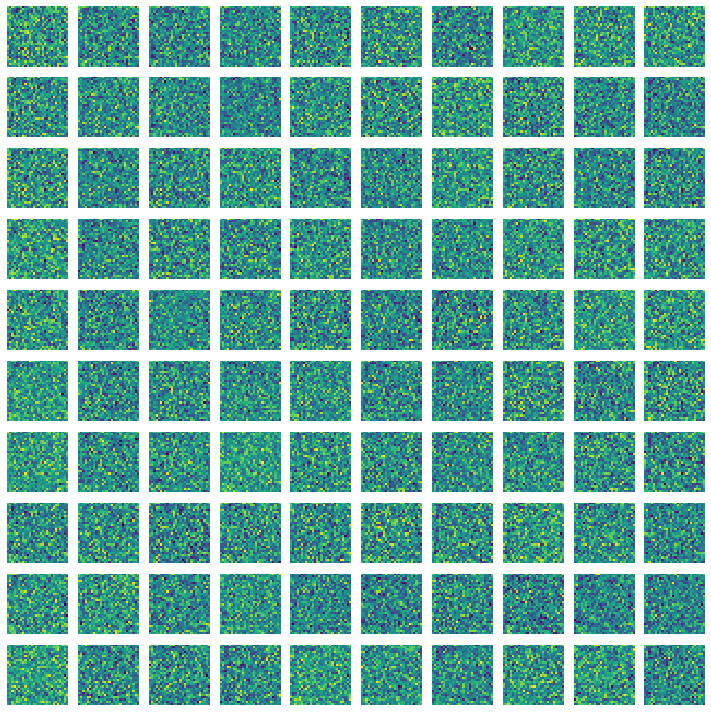

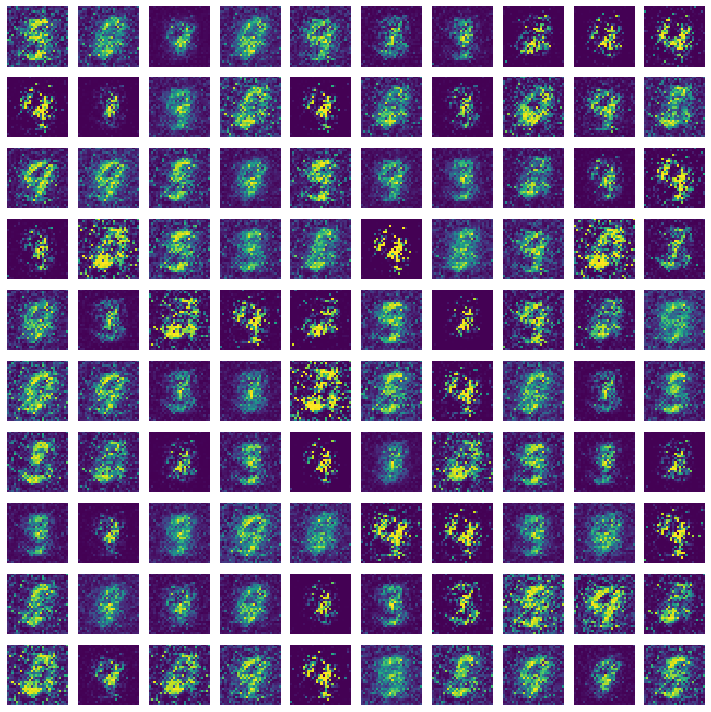

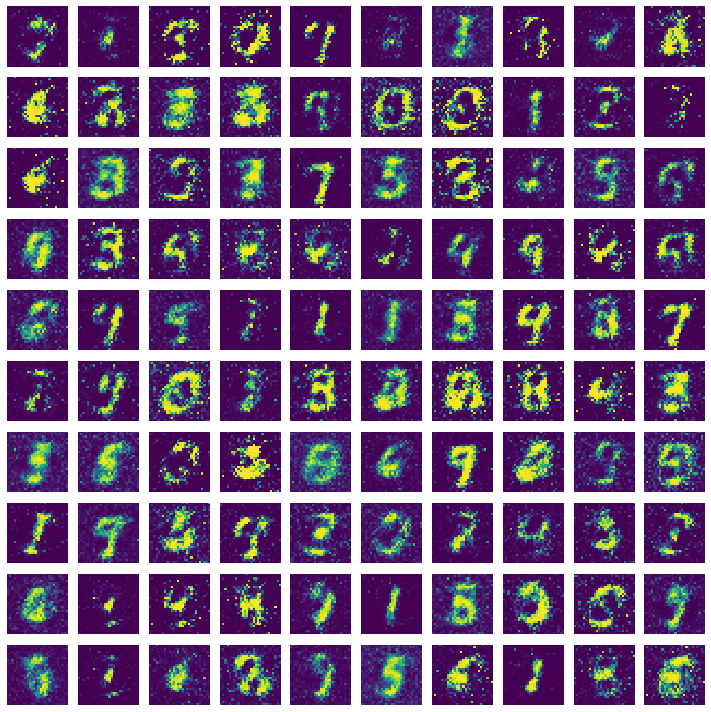

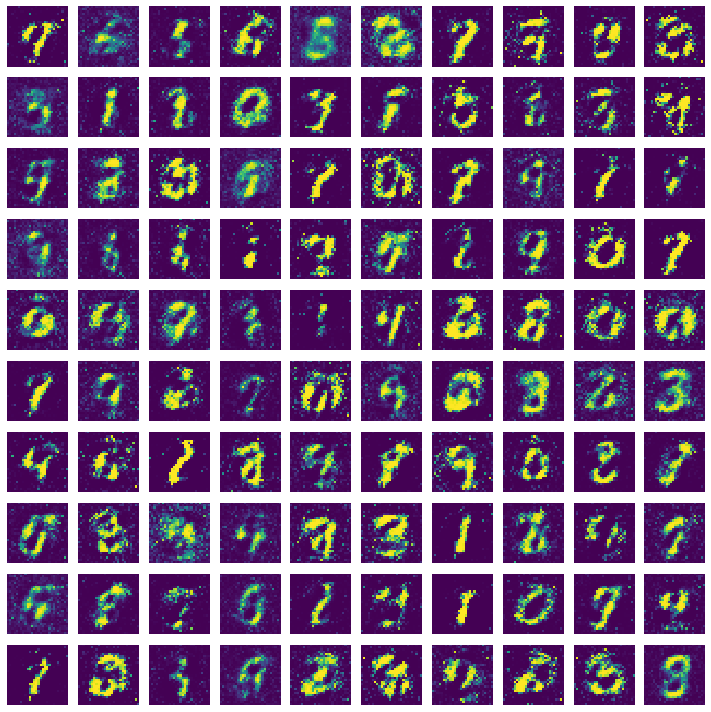

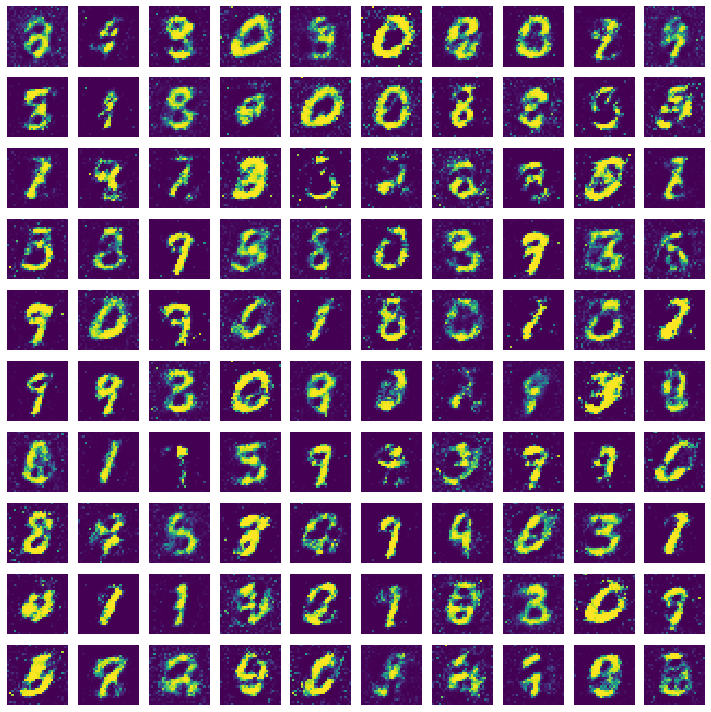

In [ ]:
batch_size = 128 # 한번에 학습시킬 양을 설정
epochs = 5000 # 반복횟수 설정

for e in tqdm(range(epochs)):
    noise= np.random.normal(0,1, [batch_size, 100]) # 128 x 100 의 노이즈 생성
    generated_images = g.predict(noise)
    # 학습을 위한 128개의 랜덤한 데이터 추출
    image_batch =mnist_data[np.random.randint(low=0,high=mnist_data.shape[0],size=batch_size)]
    # 진짜와 가짜를 합침 (아래행으로 합침)
    X= np.concatenate([image_batch, generated_images])
    # 판별자에게 전달할 결과값
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=1 # 첫 128개(image_batch)는 진짜라는 의미

    #-- 판별자 학습 과정
    d.trainable=True # 진짜 데이터 학습
    d.train_on_batch(X, y_dis) # 진짜 데이터로부터 출력되는 값과 원본을 통해 학습 -> 오차줄이기
    
    
    #-- 생성자 학습 과정
    d.trainable=False # 학습 없음
    noise= np.random.normal(0,1, [batch_size, 100])
    y_gen = np.ones(batch_size) # 판별자를 속이기 위해 모두 진짜라는 가정 (모두 1로 설정)
    gan.train_on_batch(noise, y_gen) # 가짜 데이터로부터 출력되는 값과 노이즈를 통해 학습시키기

    # 1000회 epoch 마다 이미지 생성 (중간점검)
    if e == 0 or e % 1000 == 0:    
        # 생성자가 만든 그림 확인
        plot_generated_images(g)